# Extended Tofts Model tool

This notebook shows the use of a tool to get the Tofts model parameters from DCE-MRI images. 

First install the needed libraries:

In [ ]:
pip install pydicom numpy matplotlib

In [1]:
import os
import pydicom
import numpy as np
from typing import Tuple, List, Dict, Any
import argparse
import matplotlib.pyplot as plt
import struct
import warnings

To test the method I use a DCE-MRI digital reference object of the brain [DRO](https://qidw.rsna.org/#collection/594810551cac0a4ec8ffe574/folder/5e20dcc3b3467a6a921b1304) from Bosca et al. 2016.

Source: Bosca, Ryan J., and Edward F. Jackson. “Creating an anthropomorphic digital MR phantom—an extensible tool for comparing and evaluating quantitative imaging algorithms.” Physics in Medicine & Biology 61.2 (2016): 974.

Next load the images and separate it per time point (one per second).

In [2]:
warnings.filterwarnings('ignore')
folder = "./MRI/"
dir_contents = os.listdir(folder)
shape = (len(dir_contents), 256, 256)  
Vol = np.empty(shape)
I=0
for file in dir_contents:
    file_path = os.path.join(folder, file)
    try:
        ds = pydicom.dcmread(file_path)
        arr = ds.pixel_array.astype(np.float64)
        Vol[I] = np.squeeze(arr)
        I=I+1
    except Exception as e:
        print(f"Could not read {file_path}: {e}")
        continue

VolsperTime = [Vol[x::331, :, :] for x in range(331)]
VolsperTime = [x.transpose((1,2,0)) for x in VolsperTime]
del Vol, arr

DCE-MRI images at different time points are visualized:

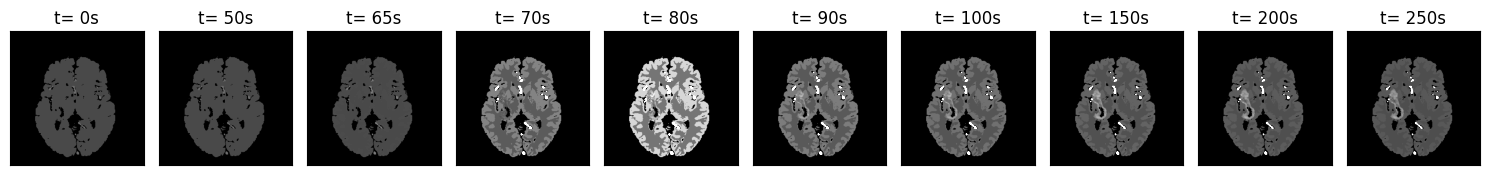

In [3]:
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
I=0
for t in [0, 50, 65, 70, 80, 90, 100, 150, 200, 250]:
    volume=VolsperTime[t]
    middle_slice = volume.shape[2] // 2
    ax=axes[I]
    I=I+1
    ax.imshow(volume[:, :, middle_slice], cmap='gray', vmin=0, vmax=1500)
    ax.set_title(f"t= {t}s")
    ax.set_xticks([])  
    ax.set_yticks([])  
plt.tight_layout()
plt.show()
del volume, middle_slice

For evaluation, Riccian noise with a given SNR is added to images by: $ SNR= \mu / \sigma$,
with $\mu$ the mean foreground intensity, and $\sigma$ the noise standard deviation.
For each time point image $Img(t)$, the new noisy image is given by:
$Img_{\sigma}(t)=\sqrt{(Img(t) + n_1)^2+{n_2}^2}$, with $n_1, n_2 \sim N(0,\sigma) $ are independent Gaussian noises.
Below the DCE-MRI images with SNR=5.

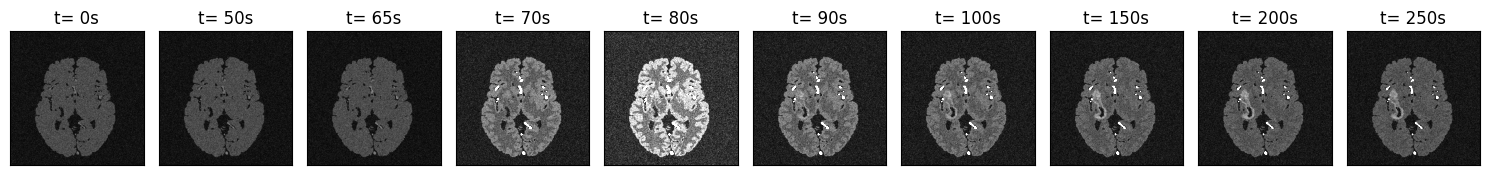

In [4]:
from AddNoise import add_noise

VolsperTime4D = np.stack(VolsperTime, axis=3)
#del VolsperTime
SNR=5
VolsperTime4Dnoise=add_noise(VolsperTime4D, SNR)    # Function to add noise to the image series

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
I=0
for t in [0, 50, 65, 70, 80, 90, 100, 150, 200, 250]:
    volume=VolsperTime4Dnoise[:,:,:,t]
    middle_slice = volume.shape[2] // 2
    ax=axes[I]
    I=I+1
    ax.imshow(volume[:, :, middle_slice], cmap='gray', vmin=0, vmax=1500)
    ax.set_title(f"t= {t}s")
    ax.set_xticks([])  
    ax.set_yticks([])  
plt.tight_layout()
plt.show()
del volume, middle_slice

Next step, from the image intensities and before contrast T1 values, it is possible to get the contrast concentration per time.
The contrast per time C(t) is defined by: $C(t)=\frac{1}{r}(R_t-R_0)$, with r the contrast relaxivity, $R_0$ the relaxation time before contrast and $R_t$ the relaxation at time t. In the DRO from Bosca et al. 2016, r=4.9$mM^{−1}\,s^{−1}$, and $R_0$ where assigned based on values defined in the paper for different brain tissues.

$R_t$ is defined by Schabel et al. 2008 by:

$$ R_t = -\frac{1}{T_r}log\left( \frac{Se(t) \,(E0-1)-E0\,(cos\, \alpha -1)}{1+cos\, \alpha \, (Se(t)\,(E0-1)-1)}  \right)  ,$$

where $T_r=5ms$, $\alpha=30^o$, $E0=e^{-T_r\, R_0}$, and the signal enhancement ratio for each time Se(t) is defined by: $Se(t)=(Img_{\sigma}(t)-Img_0)/Img_0$ with $Img_0$ the average image before contrast time (t=63s).

Below are shown concentrations curves with and without noise for 3 pixels inside tumor, and a pixel inside the artery.

Source: Schabel MC and Parker DL “Uncertainty and bias in contrast concentration measurements using spoiled gradient echo pulse sequences” Phys Med Biol (2008).



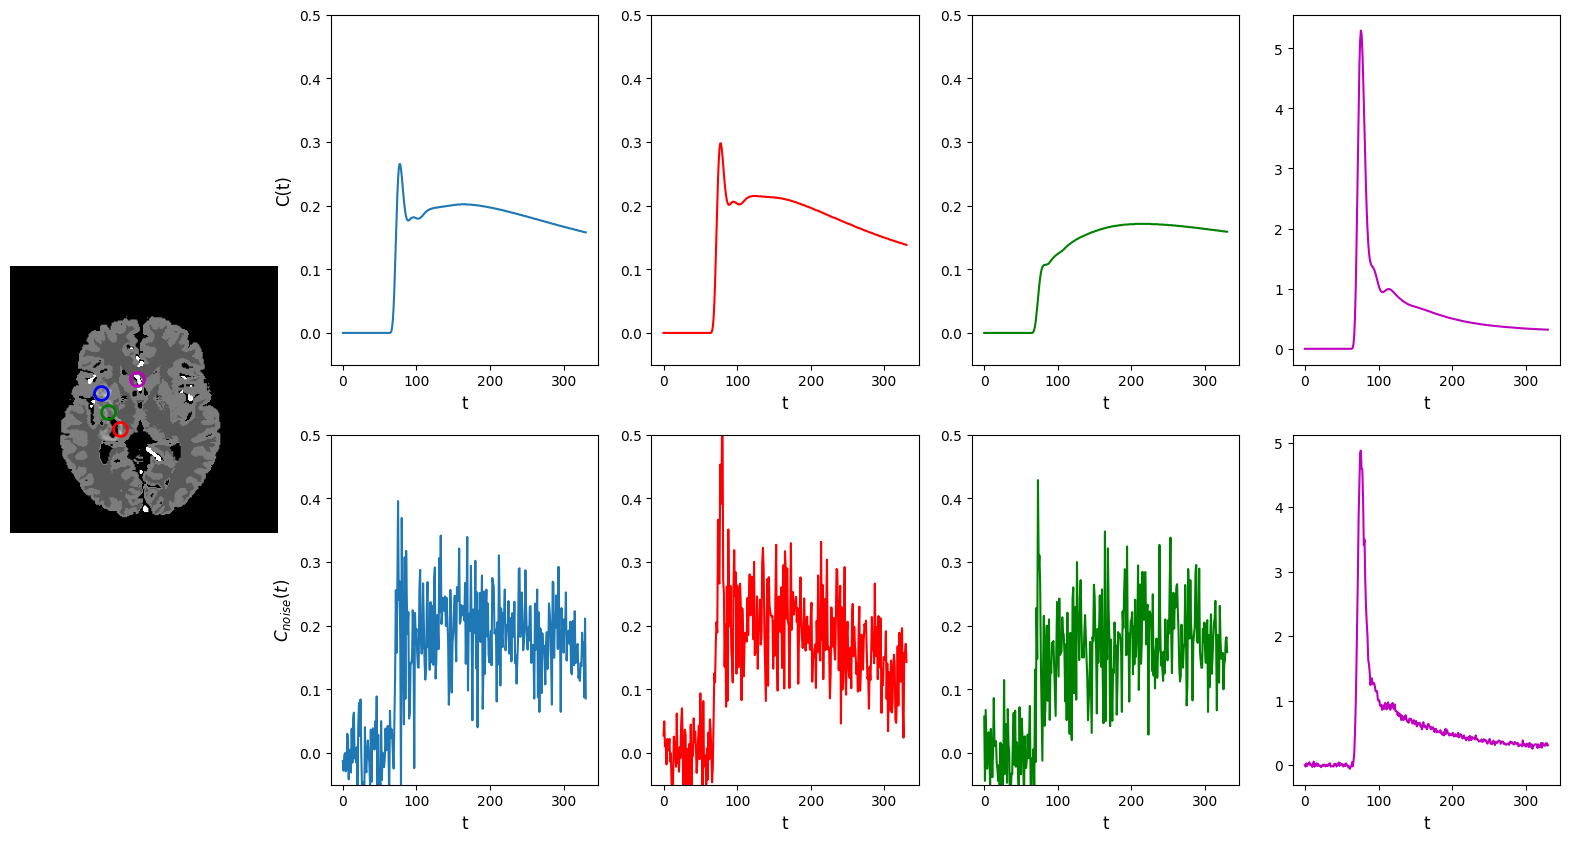

In [6]:
def GetConcentrations(VolsperTime4Dnoise):
    tr=5/1000 # 5ms
    alpha = np.radians(30)  # 30degrees
    t=63
    S0 = np.mean(VolsperTime4Dnoise[:, :, :, :t], axis=3)
    N = VolsperTime4Dnoise.shape[3] 
    Se = []
    for x in range(N):
        normalized_volume = (VolsperTime4Dnoise[:, :, :, x] - S0) / S0
        Se.append(normalized_volume)
    
    # Read the ground-truth files to get R0 values
    float64_values = []
    with open('./TruthData/True_vp.raw', 'rb') as f:
        while True:
                data = f.read(8)
                if not data:  
                    break
                value = struct.unpack("<d", data)[0]
                float64_values.append(value)
    float64_values=np.array(float64_values)
    vp_raw = float64_values.reshape((12, 256, 256))    
    vp_raw = np.transpose(vp_raw, (2, 1, 0))
    del float64_values, data
    
    with open('./TruthData/tumor_mask.raw', 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8)
    mask_raw = data.reshape((12, 256, 256))    
    mask_raw = np.transpose(mask_raw, (2, 1, 0))
    del data
    
    T10 = np.zeros_like(S0)  
    del S0
    T10[vp_raw == 0.02] = 1084 / 1000  # 1084ms → 1.084
    T10[vp_raw == 0.04] = 1820 / 1000  # 1820ms → 1.820
    T10[vp_raw == 0.55] = 1440 / 1000  # 1440ms → 1.440
    T10[mask_raw == 1] = 1  # 1000ms
    
    del mask_raw
    del vp_raw
    
    R0 = 1 / T10
    del T10
    E0 = np.exp(-tr*R0)
    Rt = [
        np.real((-1/tr) * np.log(
            (s * (E0 - 1) - E0 * (np.cos(alpha) - 1)) / 
            (1 + np.cos(alpha) * (s * (E0 - 1) - 1))
        ))
        for s in Se
    ]
    del Se, E0
    
    r = 4.9
    C = [(1/r) * (x - R0) for x in Rt]
    del Rt
    
    C4D = np.stack(C, axis=3)  
    return C4D

C4Dnoise=GetConcentrations(VolsperTime4Dnoise)
C4D=GetConcentrations(VolsperTime4D)

# Visualize concentration curves
Vol=VolsperTime4D[:, :, 6, 90]
Voxel1noise=C4Dnoise[121,87,6,:]
Voxel2noise=C4Dnoise[156,105,6,:]
Voxel3noise=C4Dnoise[139,93,6,:]
Canoise=C4Dnoise[108,121,6,:]
Voxel1=C4D[121,87,6,:]
Voxel2=C4D[156,105,6,:]
Voxel3=C4D[139,93,6,:]
Ca=C4D[108,121,6,:]

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 5, width_ratios=[1, 1, 1, 1, 1])
ax0 = fig.add_subplot(gs[:, 0])
ax0.imshow(Vol, cmap='gray', vmin=0, vmax=1500)
ax0.plot(87, 121, 'bo', markersize=10, fillstyle='none', markeredgewidth=2)
ax0.plot(105, 156, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)
ax0.plot(93, 139, 'go', markersize=10, fillstyle='none', markeredgewidth=2)
ax0.plot(121, 108, 'mo', markersize=10, fillstyle='none', markeredgewidth=2)
#ax0.set_title(titles[0], fontsize=12)
ax0.axis('off')

ax = fig.add_subplot(gs[0, 1])
ax.plot(np.array(range(0,len(Voxel1))),Voxel1)
ax.set_ylim(-0.05,0.5)
ax.set_ylabel('C(t)', fontsize=12) 
ax.set_xlabel('t', fontsize=12) 
#ax.set_title(titles[i+1], fontsize=10)
ax.axis('on')
ax = fig.add_subplot(gs[0, 2])
ax.plot(np.array(range(0,len(Voxel2))),Voxel2, 'r')
ax.set_ylim(-0.05,0.5)
ax.set_xlabel('t', fontsize=12) 
#ax.set_title(titles[i+1], fontsize=10)
ax.axis('on')
ax = fig.add_subplot(gs[0, 3])
ax.plot(np.array(range(0,len(Voxel3))),Voxel3, 'g')
ax.set_ylim(-0.05,0.5)
ax.set_xlabel('t', fontsize=12) 
#ax.set_title(titles[i+1], fontsize=10)
ax.axis('on')
ax = fig.add_subplot(gs[0, 4])
ax.plot(np.array(range(0,len(Ca))),Ca, 'm')
ax.set_xlabel('t', fontsize=12) 
#ax.set_title(titles[i+1], fontsize=10)
ax.axis('on')

ax = fig.add_subplot(gs[1, 1])
ax.plot(np.array(range(0,len(Voxel1noise))),Voxel1noise)
ax.set_ylim(-0.05,0.5)
ax.set_ylabel(r'$C_{noise}(t)$', fontsize=12) 
ax.set_xlabel('t', fontsize=12) 
#ax.set_title(titles[i+1], fontsize=10)
ax.axis('on')
ax = fig.add_subplot(gs[1, 2])
ax.plot(np.array(range(0,len(Voxel2noise))),Voxel2noise,'r')
ax.set_ylim(-0.05,0.5)
ax.set_xlabel('t', fontsize=12) 
#ax.set_title(titles[i+1], fontsize=10)
ax.axis('on')
ax = fig.add_subplot(gs[1, 3])
ax.plot(np.array(range(0,len(Voxel3noise))),Voxel3noise, 'g')
ax.set_ylim(-0.05,0.5)
ax.set_xlabel('t', fontsize=12) 
#ax.set_title(titles[i+1], fontsize=10)
ax.axis('on')
ax = fig.add_subplot(gs[1, 4])
ax.plot(np.array(range(0,len(Canoise))),Canoise, 'm')
ax.set_xlabel('t', fontsize=12) 
#ax.set_title(titles[i+1], fontsize=10)
ax.axis('on')
ax0.set_xticks([])
ax0.set_yticks([])

plt.show()

According to Tofts and Brix 1999, the concentration C(t) depends of three tissue parameters: $K^{trans}$, $V_e$, and $V_p$ by:

$C(t) = K^{trans} \cdot \int_0^t C_p(\mathbf{u}) \cdot e^{-\frac{K^{trans}}{V_e}(t-\mathbf{u})} d\mathbf{u} + V_p \cdot C_p(t)$,

where $C_p(t)$ is the plasma concentration, given by: $C_p(t)=\frac{C_A(t)}{(1-Hct)}$, where $C_A$ is the artery concentration and Hct the hematocrit with Hct=0.45 in Bosca et al. 2016.

By Murase 2004, the tissue parameters can be obtained by solving the following linear system of equations:

$
\begin{pmatrix}
C(t_1) \\
C(t_2) \\
\vdots \\
C(t_n)
\end{pmatrix}
=
\begin{pmatrix}
\int_{0}^{t_1} C_p(u) \, du & -\int_{0}^{t_1}  C(u) \, du & C_p(t_1) \\
\int_{0}^{t_2} C_p(u) \, du & -\int_{0}^{t_2}  C(u) \, du & C_p(t_2) \\
\vdots & \vdots & \vdots \\
\int_{0}^{t_n} C_p(u) \, du & -\int_{0}^{t_n}  C(u) \, du & C_p(t_n)
\end{pmatrix}
\begin{pmatrix}
K^{trans}+\frac{K^{trans}}{V_e}V_p \\
\frac{K^{trans}}{V_e} \\
V_p
\end{pmatrix}
$

For the full image with N pixels, this can be re-arranged to obtain the parameters using a single system of equations: $[A_1\, A_2\, A_3]_{nN \times 3N} \, X_{3N \times 1} = B_{nN \times 1}$, where

$A_1=
\left(
\begin{array}{cccc}
\int_{0}^{t_1} C_p(u) \, du & 0 & \cdots & 0 \\
\int_{0}^{t_2} C_p(u) \, du &   &  &  \\
\vdots & \vdots &  & \vdots \\
\int_{0}^{t_n} C_p(u) \, du & 0 &  & \\
0 & \int_{0}^{t_1} C_p(u) \, du &  &  \\
\vdots & \vdots &  &  \\
 & \int_{0}^{t_n} C_p(u) \, du & \cdots & 0\\
 &  & \ddots & \\
0 &  &  & \int_{0}^{t_n} C_p(u) \, du
\end{array}
\right)_{nN \times N}
$,     $A_2=
\left(
\begin{array}{cccc}
-\int_{0}^{t_1}  C^1(u) \, du & 0 & \cdots & 0 \\
-\int_{0}^{t_2}  C^1(u) \, du &   &  &  \\
\vdots & \vdots &  & \vdots \\
-\int_{0}^{t_n} C^1(u) \, du & 0 &  & \\
0 & -\int_{0}^{t_1}  C^2(u) \, du &  &  \\
\vdots & \vdots &  &  \\
 & -\int_{0}^{t_n} C^2(u) \, du & \cdots & 0\\
 &  & \ddots & \\
0 &  &  & -\int_{0}^{t_n} C^N(u) \, du
\end{array}
\right)_{nN \times N}
$,

$A_3=
\left(
\begin{array}{cccc}
C_p(t_1) & 0 & \cdots & 0 \\
C_p(t_2) &   &  &  \\
\vdots & \vdots &  & \vdots \\
C_p(t_n) & 0 &  & \\
0 & C_p(t_1) &  &  \\
\vdots & \vdots &  &  \\
 & C_p(t_n) & \cdots & 0\\
 &  & \ddots & \\
0 &  &  & C_p(t_n)
\end{array}
\right)_{nN \times N}
$,  $B=
\begin{pmatrix}
C^1(t_1) \\
C^1(t_2) \\
\vdots \\
C^1(t_n)\\
C^2(t_1) \\
\vdots \\
C^2(t_n)\\
\vdots \\
C^N(t_1) \\
\vdots \\
C^N(t_n)
\end{pmatrix}_{nN \times 1}
$,  $X=
\begin{pmatrix}
K_1^{trans}+\frac{K_1^{trans}}{V_e^1}V_p^1 \\
K_2^{trans}+\frac{K_2^{trans}}{V_e^2}V_p^2 \\
\vdots \\
K_N^{trans}+\frac{K_N^{trans}}{V_e^N}V_p^N \\
\frac{K_1^{trans}}{V_e^1} \\
\vdots \\
\frac{K_N^{trans}}{V_e^N} \\
V_p^1 \\
\vdots \\
V_p^N
\end{pmatrix}_{3N \times 1}
$.

The sub-index and super-index in $C$, $K^{trans}$, $V_e$, and $V_p$ are the values for each pixel position.

Source: Murase “Efficient Method for Calculating Kinetic Parameters Using T1-Weighted Dynamic Contrast-Enhanced Magnetic Resonance Imaging” Magnetic Resonance in Medicine (2004).

In [7]:
from scipy.sparse import lil_matrix, eye
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import spsolve
from scipy.integrate import cumulative_trapezoid
from scipy.io import savemat

def perfusion_parameters(C4D, AIF_points, to=63, lambda_reg=1e-6):
    """
    Estimate perfusion parameters (Vp, Ve, Kt) from 4D concentration data
    
    Parameters:
        C4D (numpy.ndarray): 4D matrix of concentration curves (x,y,z,time)
        AIF_points (list): 3-element list of [x,y,z] coordinates for AIF
        to (int): Time point of contrast injection (default=63)
        lambda_reg (float): Regularization parameter (default=1e-6)
        
    Returns:
        tuple: (Vp, Ve, Kt) - 3D arrays of perfusion parameters
    """
    # Crop concentration data
    C4D = C4D[:, :, :, to-1:]
    cond = ~np.any(np.isnan(C4D), axis=3)
    IdCond = np.array(np.where(cond.flatten()))
    N = np.sum(cond)
    del cond
    
    # Get plasma concentration Cp
    Cp = C4D[AIF_points[0], AIF_points[1], AIF_points[2], :] / (1 - 0.45)
    n = len(Cp) - 1

    # Build A1 matrix
    # A1=[S(0->t1)cpdu 0               ... 0 ]
    #     S(0->t2)cpdu 0               ... 0 ]
    #     .                            ... 0 ]
    #     S(0->tn)cpdu 0               ... 0 ]
    #     0            S(0->t1)cpdu    ... 0 ]
    #     0            .               ... 0 ]
    #     0            S(0->tn)cpdu    ... 0 ]
    #     0            0    ... S(0->t1)cpdu ]
    #     0            0    ...            . ]
    #     0            0    ... S(0->tn)cpdu ]nNxN 
    
    # Build Cp integrals (A1 matrix component)
    CpI = np.array([np.trapz(Cp[:x+1], dx=1) for x in range(1, n+1)])
    
    idxi = np.arange(n * N)
    idxj = np.repeat(np.arange(N), n)  
    A = lil_matrix((n * N, 3 * N))
    A[idxi, idxj] = np.tile(CpI, N)   
    
    # A2=[-S(0->t1)ctdu 0               ... 0 ]
    #     -S(0->t2)ctdu 0               ... 0 ]
    #     .                            ... 0 ]
    #     -S(0->tn)ctdu 0               ... 0 ]
    #     0            -S(0->t1)ctdu    ... 0 ]
    #     0            .               ... 0 ]
    #     0            -S(0->tn)ctdu    ... 0 ]
    #     0            0    ... -S(0->t1)ctdu ]
    #     0            0    ...            . ]
    #     0            0    ... -S(0->tn)ctdu ]nNxN  
    
    orig_shape = C4D.shape
    C2D = C4D.reshape(-1, orig_shape[3])
    C2D=C2D[IdCond,:]
    C2D=C2D[0]
    
    CtI = cumulative_trapezoid(C2D, axis=1)
    CtI = CtI.flatten()   
    A[idxi, idxj+N] = -CtI
        
    # A3=[Cp(t1) 0               ... 0 ]
    #     Cp(t2) 0               ... 0 ]
    #     .                      ... 0 ]
    #     Cp(tn) 0               ... 0 ]
    #     0            Cp(t1)    ... 0 ]
    #     0            .         ... 0 ]
    #     0            Cp(tn)    ... 0 ]
    #     0            0    ... Cp(t1) ]
    #     0            0    ...      . ]
    #     0            0    ... Cp(tn) ]nNxN 
    
    A[idxi, idxj+2*N] = np.tile(Cp[1:], N)
    
    b = C2D[:, 1:].flatten()
    
    # Solve system with regularization
    del C2D,C4D,CtI,idxi,idxj 
    A = A.tocsr()
    AtA = A.T @ A   
    AtA_reg = AtA + lambda_reg * eye(AtA.shape[1])
    x = spsolve(AtA_reg, A.T @ b)
    x1 = x[:N]
    x2 = x[N:2*N]
    x3 = x[2*N:]  
    
    vp = x3 
    ve = (x1 / x2) - x3
    Ktrans = x1 - x2 * x3
    
    # Reshape to original dimensions
    Vp = np.zeros(orig_shape[:3])
    Vp.put(IdCond,vp)
    
    Ve = np.zeros(orig_shape[:3])
    Ve.put(IdCond,ve)
    Ve = np.nan_to_num(Ve)  
    
    Kt = np.zeros(orig_shape[:3])
    Kt.put(IdCond,Ktrans)
    
    return Vp, Ve, Kt

C4D2=C4D[100-1:200,50-1:150,:,:]    
C4D=C4D2
del C4D2, VolsperTime4D, VolsperTime4Dnoise 
Vp,Ve,Kt=perfusion_parameters(C4D, [108+1-100,121+1-50,6], to=63, lambda_reg=1e-6)    # Get parameters for images without noise
C4Dnoise2=C4Dnoise[100-1:200,50-1:150,:,:]    
C4Dnoise=C4Dnoise2
del C4Dnoise2
Vp_noise,Ve_noise,Kt_noise=perfusion_parameters(C4Dnoise, [108+1-100,121+1-50,6], to=63, lambda_reg=1e-6) # Get parameters for images with noise


Below the ground-truth and estimated parameters maps for images with and without noise.

Also error plots for each tumor pixel for images with and without noise.

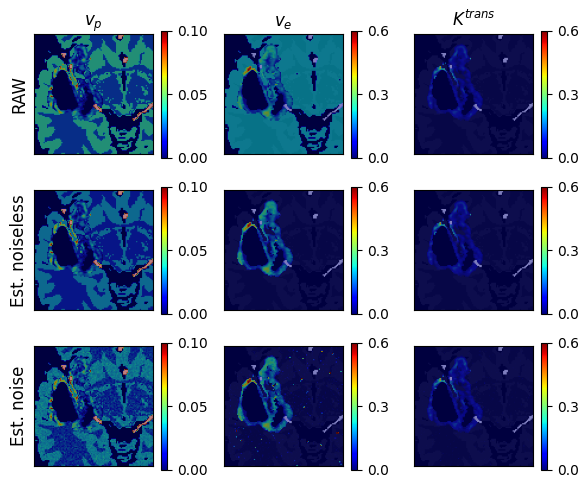

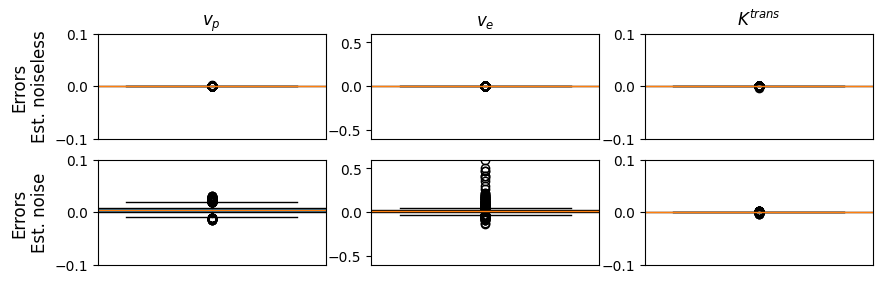

In [8]:
# Read the binary file
Strs=['./TruthData/True_vp.raw', './TruthData/True_ve.raw', './TruthData/True_KTrans.raw']
Outs=[[], [], []]
I=0
for Str in Strs:
    float64_values = []
    with open(Str, 'rb') as f:
        while True:
                # Read 8 bytes (size of a float64)
                data = f.read(8)
                if not data:  # End of file
                    break
                # Unpack the 8 bytes as a little-endian float64
                value = struct.unpack("<d", data)[0]
                float64_values.append(value)
    float64_values=np.array(float64_values)
    Outs[I] = float64_values.reshape((12, 256, 256))    
    Outs[I] = np.transpose(Outs[I], (2, 1, 0))
    del float64_values, data
    I=I+1
vp_raw, ve_raw, kt_raw = Outs
with open('./TruthData/tumor_mask.raw', 'rb') as f:
    data = np.fromfile(f, dtype=np.uint8)
mask_raw = data.reshape((12, 256, 256))    
mask_raw = np.transpose(mask_raw, (2, 1, 0))
mask_raw=mask_raw[100-1:200,50-1:150,:]
vp_raw=vp_raw[100-1:200,50-1:150,:]
ve_raw=ve_raw[100-1:200,50-1:150,:]
kt_raw=kt_raw[100-1:200,50-1:150,:]

volume=VolsperTime[80]
baseImage=volume[100-1:200,50-1:150,5]
baseImage = baseImage / np.max(baseImage)  
rgbSlice = np.stack((baseImage, baseImage, baseImage), axis=-1)     
    
fig, axes = plt.subplots(3, 3, figsize=(6, 5))
for I in range(0,3):
    if I==0:
        vp_img=vp_raw;ve_img=ve_raw;kt_img=kt_raw;
    if I==1:
        vp_img=Vp;ve_img=Ve;kt_img=Kt;
    if I==2:
        vp_img=Vp_noise;ve_img=Ve_noise;kt_img=Kt_noise;
        
    ax=axes[I,0];ax.set_xticks([]);ax.set_yticks([])
    img1=ax.imshow(vp_img[:, :, 5], cmap='jet', vmin=0, vmax=0.1)
    ax.imshow(rgbSlice, alpha=0.5)  
    fig.colorbar(img1, ax=axes[I,0], ticks=[0, 0.05, 0.1]) 
    if I==0:
        ax.set_title('$v_p$')
        ax.set_ylabel('RAW', fontsize=12) 
    if I==1:   
        ax.set_ylabel('Est. noiseless', fontsize=12) 
    if I==2:   
        ax.set_ylabel('Est. noise', fontsize=12) 
    
    ax=axes[I,1];ax.set_xticks([]);ax.set_yticks([])
    img1=ax.imshow(ve_img[:, :, 5], cmap='jet', vmin=0, vmax=0.6)
    ax.imshow(rgbSlice, alpha=0.5)  
    fig.colorbar(img1, ax=axes[I,1], ticks=[0, 0.3, 0.6]) 
    if I==0:
        ax.set_title('$v_e$')
    
    ax=axes[I,2];ax.set_xticks([]);ax.set_yticks([])
    img1=ax.imshow(kt_img[:, :, 5]*60, cmap='jet', vmin=0, vmax=0.6)
    ax.imshow(rgbSlice, alpha=0.5)  
    fig.colorbar(img1, ax=axes[I,2], ticks=[0, 0.3, 0.6]) 
    if I==0:
        ax.set_title('$K^{trans}$')

plt.tight_layout()
plt.show()

mask_raw = mask_raw.astype(bool)
ErrorKt=Kt[mask_raw]-kt_raw[mask_raw]
ErrorVp=Vp[mask_raw]-vp_raw[mask_raw]
ErrorVe=Ve[mask_raw]-ve_raw[mask_raw]

ErrorKtnoise=Kt_noise[mask_raw]-kt_raw[mask_raw]
ErrorVpnoise=Vp_noise[mask_raw]-vp_raw[mask_raw]
ErrorVenoise=Ve_noise[mask_raw]-ve_raw[mask_raw]

fig, axes = plt.subplots(2, 3, figsize=(10, 3))
ax=axes[0,0]
ax.boxplot(ErrorVp, vert=True, patch_artist=True)
ax.set_xticks([]) 
ax.set_title('$v_p$')
ax.set_ylim(-0.1,0.1)
ax.set_xlim(0.95,1.05)
ax.set_ylabel('Errors\nEst. noiseless', fontsize=12) 
ax=axes[0,1]
ax.boxplot(ErrorVe, vert=True, patch_artist=True)
ax.set_xticks([]) 
ax.set_title('$v_e$')
ax.set_ylim(-0.6,0.6)
ax.set_xlim(0.95,1.05)
ax=axes[0,2]
ax.boxplot(ErrorKt, vert=True, patch_artist=True)
ax.set_xticks([]) 
ax.set_title('$K^{trans}$')
ax.set_ylim(-0.1,0.1)
ax.set_xlim(0.95,1.05)

ax=axes[1,0]
ax.boxplot(ErrorVpnoise, vert=True, patch_artist=True)
ax.set_xticks([]) 
ax.set_ylim(-0.1,0.1)
ax.set_xlim(0.95,1.05)
ax.set_ylabel('Errors\nEst. noise', fontsize=12) 
ax=axes[1,1]
ax.boxplot(ErrorVenoise, vert=True, patch_artist=True)
ax.set_xticks([]) 
ax.set_ylim(-0.6,0.6)
ax.set_xlim(0.95,1.05)
ax=axes[1,2]
ax.boxplot(ErrorKtnoise, vert=True, patch_artist=True)
ax.set_xticks([]) 
ax.set_ylim(-0.1,0.1)
ax.set_xlim(0.95,1.05)

plt.show()


## Conclusion

In this notebook I presented a method to get the Tofts model parameters from DCE-MRI images. 

The parameters are obtained by solving a single linear system of equations which allows to include a spatial regularization.

The method is tested using brain DRO from Bosca et al. 2016. Results obtained are almost the same to the ground-truth parameters and very close using the images with a noise of SNR=5.

There were differences in healthy tissue parameters because in Bosca et al. 2016 two different Cp where used to simulate the images in tumor and healthy tissue, and only the Cp used in tumor was clearly described.

This method could be used to get Tofts model parameters from DCE-MRI images for quantitative image analysis.

